In [2]:
from matplotlib import pyplot as plt
from Ham_generator import *
from qcels import *
import qiskit
import pickle
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
from qiskit_ibm_runtime import QiskitRuntimeService as QRS
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer.noise import NoiseModel, depolarizing_error, QuantumError, coherent_unitary_error, ReadoutError, thermal_relaxation_error
import matplotlib
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10 
np.set_printoptions(threshold=np.inf)

In [3]:
num_sites = 4

#TFIM parameters
J_T = 1
g_T = 4

#HSM parameters
J_H = 4
g_H = 0

#Hubb parameters
t_H = 1
U_H = 1

#H2 molecule parameters
distance = 0.5

Transverse Field Ising Model


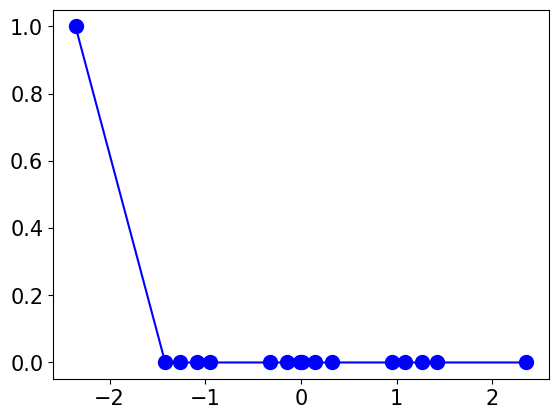

In [4]:
# T (TFIM), H (HSM), B (Hubbard), M (H2 molecule)
model_type = 'T'
# Q (Qiskit), F(F3C++)
Ham_type = 'Q'

if model_type[0].upper() == 'T':
    mn = 'TFIM'
    print('Transverse Field Ising Model')

    if Ham_type[0].upper() == 'F':
        unitaries, ham = (generate_TFIM_gates(num_sites, 2, 1, g_T, ham_shift, '../../../f3cpp', trotter = 10))
        eigenenergies, eigenenstates = eigh(ham)
        ground_state = eigenenstates[:,0]
        
    if Ham_type[0].upper() == 'Q':
        ham = create_hamiltonian(num_sites, 'TFIM', ham_shift, g = g_T, J=J_T, show_steps=False)
        eigenenergies, eigenstates = eigh(ham)
        ground_state = eigenstates[:,0]

        pop = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

        plt.plot(eigenenergies, pop, 'b-o')
        plt.show()
    
if model_type[0].upper() == 'H':
    mn = 'HSM'
    print('Heisenberg Spin Model')

    ham = create_hamiltonian(num_sites, 'SPIN', ham_shift, g = g_H, J=J_H, show_steps=False)
    eigenenergies, eigenstates = eigh(ham)
    ground_state = eigenstates[:,0]

    pop = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

    plt.plot(eigenenergies, pop, 'b-o')
    plt.show()

if model_type[0].upper() == 'B':
    mn = "HUBB"
    print('Hubbard Model')

    ham = create_hamiltonian(num_sites, 'HUBB', ham_shift, t = t_H, U=U_H, x = num_sites, y = 1, show_steps=False)
    eigenenergies, eigenstates = eigh(ham)
    ground_state = eigenstates[:,0]

    popp = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

    plt.plot(eigenenergies, popp, 'b-o')
    plt.show()

if model_type[0].upper() == 'M':
    mn = 'HH'
    num_sites = 1
    ang = 0.52917721092
    print('H2 Molecule')

    ham = create_hamiltonian(num_sites, 'H2', ham_shift, show_steps=False)
    eigenenergies, eigenstates = eigh(ham)
    ground_state = eigenstates[:,0]

    popp = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

    plt.plot(eigenenergies, popp, 'b-o')
    plt.show()

In [5]:
print(eigenenergies[0])

-2.3561944901923457


In [6]:
# num_sites = 3
# ham = np.diag(np.linspace(-3*np.pi/4,3*np.pi/4, 8))
# eigenenergies, eigenstates = eigh(ham)
# ground_state = eigenstates[:,0]
# print(eigenenergies[0])

# popp = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

# plt.plot(eigenenergies, popp, 'b-o')
# plt.show()

In [7]:
# initialization: S (Quantum Simulation), or R (Quantum Hardware)

computation_type = 'S'
output_file = True
p0_array            = np.array([0.6, 0.8]) # initial overlap with the first eigenvector
deltas              = np.sqrt(1-p0_array)
trials              = 5 # number of comparisions each test (circuit depths)
tests               = 5
err_threshold       = 0.01
T0                  = 100

# QCELS variables
time_steps          = 5
epsilons            = np.logspace(-1,-8, trials)
print('Chosen epsilons', epsilons)
iterations          = [int(np.ceil(np.log2(1/i)) + 1) for i in epsilons] # add +1 (not -1) inside int
epsilons            = [2**(1 - i) for i in iterations]
err_QCELS           = np.zeros((len(p0_array),trials))
est_QCELS           = np.zeros((len(p0_array),trials))
cost_list_avg_QCELS = np.zeros((len(p0_array),trials))
rate_success_QCELS  = np.zeros((len(p0_array),trials))
max_T_QCELS         = np.zeros((len(p0_array),trials))

print('Iterations', iterations)
print('Real epsilons', epsilons)

Chosen epsilons [1.00000000e-01 1.77827941e-03 3.16227766e-05 5.62341325e-07
 1.00000000e-08]
Iterations [5, 11, 16, 22, 28]
Real epsilons [0.0625, 0.0009765625, 3.0517578125e-05, 4.76837158203125e-07, 7.450580596923828e-09]


In [8]:
# initialization: S (Quantum Simulation), or R (Quantum Hardware)

if computation_type[0].upper() == 'S':
    print("\nQUANTUM SIMULATION SELECTED\n")

    noise_model = NoiseModel()
    backend = AerSimulator(noise_model=noise_model)
    data_name = "Q_Sim"

if computation_type[0].upper() == 'R':
    print("\nQUANTUM HARDWARE SELECTED\n")    
    
    # save qiskit API token for later use
    api_token = input("Enter API Token:")
    service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
    backend = service.backend('ibm_rensselaer')
    data_name = "Q_Real"

if output_file:
    outfile = open("Output/"+str(data_name)+"_"+str(mn)+"_trans.txt", 'w')


QUANTUM SIMULATION SELECTED



In [9]:
ansatz = []
for p in range(len(p0_array)):
    psi = ground_state

    # Generate a random vector orthogonal to psi
    random_vec = np.random.randn(2**num_sites) + 1j * np.random.randn(2**num_sites)
    random_vec -= np.vdot(psi, random_vec) * psi  # Make orthogonal to psi
    random_vec /= np.linalg.norm(random_vec)  # Normalize

    # Construct psi with the required squared overlap
    overlap_squared = p0_array[p]
    phi = np.sqrt(overlap_squared) * psi + np.sqrt(1 - overlap_squared) * random_vec

    print(np.abs(np.vdot(psi, phi))**2)
    ansatz.append(phi)

0.6000000000000011
0.8000000000000009


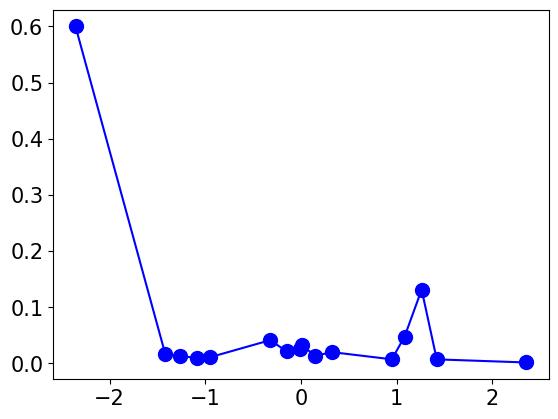

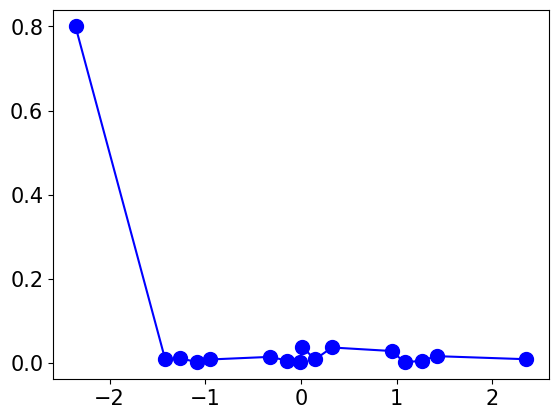

In [10]:
for p in range(len(p0_array)):
    pop = np.abs(np.dot(eigenstates.conj().T, ansatz[p]))**2

    plt.plot(eigenenergies, pop, 'b-o')
    plt.show()

In [11]:
# Create and run HT for lambda_prior

circs = []
if Ham_type[0].upper() == 'F':
    print('F3C++')
    for p in range(len(p0_array)):
        trans_qc1 = create_HT_circuit(num_sites, unitaries[-1], W = 'Re', backend = backend, init_state = ansatz[p])
        trans_qc2 = create_HT_circuit(num_sites, unitaries[-1], W = 'Im', backend = backend, init_state = ansatz[p])
        

        circs.append(trans_qc1)
        circs.append(trans_qc2)

    sampler = Sampler(backend)
    job = sampler.run(circs, shots = 10000)
    lambda_results = job.result()

if Ham_type[0].upper() == 'Q':
    print('Qiskit')
    for p in range(len(p0_array)):
        mat = expm(-1j*ham)
        controlled_U = UnitaryGate(mat).control(annotated="yes")

        trans_qc1 = create_HT_circuit(num_sites, controlled_U, W = 'Re', backend = backend, init_state = ansatz[p])
        trans_qc2 = create_HT_circuit(num_sites, controlled_U, W = 'Im', backend = backend, init_state = ansatz[p])

        circs.append(trans_qc1)
        circs.append(trans_qc2)

    sampler = Sampler(backend)
    job = sampler.run(circs, shots = 10000)
    lambda_results = job.result()

Qiskit


In [12]:
# Get lambda_prior
lambda_priors = []

re_data1 = lambda_results[0].data
im_data1 = lambda_results[1].data

re_data2 = lambda_results[2].data
im_data2 = lambda_results[3].data


counts_re1 = re_data1[list(re_data1.keys())[0]].get_counts()
counts_im1 = im_data1[list(im_data1.keys())[0]].get_counts()

counts_re2 = re_data2[list(re_data2.keys())[0]].get_counts()
counts_im2 = im_data2[list(im_data2.keys())[0]].get_counts()


re_p0 = im_p0 = 0
if counts_re1.get('0') is not None:
    re_p0 = counts_re1['0']/10000
if counts_im1.get('0') is not None:
    im_p0 = counts_im1['0']/10000

Re = 2*re_p0 - 1
Im = 2*im_p0 - 1

Angle = np.arccos(Re)
if  np.arcsin(Im)<0:
    Phase = 2*np.pi - Angle
else:
    Phase = Angle

lambda_prior = -Phase
lambda_priors.append(lambda_prior)


re_p0 = im_p0 = 0
if counts_re2.get('0') is not None:
    re_p0 = counts_re2['0']/10000
if counts_im2.get('0') is not None:
    im_p0 = counts_im2['0']/10000

Re = 2*re_p0 - 1
Im = 2*im_p0 - 1

Angle = np.arccos(Re)
if  np.arcsin(Im)<0:
    Phase = 2*np.pi - Angle
else:
    Phase = Angle

lambda_prior = -Phase
lambda_priors.append(lambda_prior)

In [13]:
print('lambda_priors: ', lambda_priors, '\n target: ', eigenenergies[0])

lambda_priors:  [-1.7713378189436557, -2.017283785836762] 
 target:  -2.3561944901923457


In [313]:
# Transpiles circuits
times = []
for p in range(len(p0_array)):
    p0=p0_array[p]
    delta = deltas[p]

    print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

    if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

    print("  Generating QCELS circuits", "(p0="+str(p0)+")")

    #------------------QCELS-----------------
    for trial in range(trials):
        print("    Transpiling QCELS", "("+str(trial+1)+"/"+str(trials)+")")
        
        if output_file: print("    Transpiling QCELS", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush = True)

        epsilon = epsilons[trial]
        for j in range(iterations[trial] + 1):
            tau = get_tau(j, time_steps, epsilon, delta)
            qcs_QCELS = []
            if Ham_type[0].upper() == 'F':
                unitaries, _ = (generate_TFIM_gates(num_sites, time_steps, tau, g_T, ham_shift, '../../../f3cpp', trotter = 10))
            for data_pair in range(time_steps):
                if Ham_type[0].upper() == 'Q':
                    t = tau*data_pair
                    times.append(t)
                    mat = expm(-1j*ham*t) 
                    controlled_U = UnitaryGate(mat).control(annotated="yes")
                    qcs_QCELS.append(create_HT_circuit(num_sites, controlled_U, W = 'Re', backend = backend, init_state = ansatz[p]))
                    qcs_QCELS.append(create_HT_circuit(num_sites, controlled_U, W = 'Im', backend = backend, init_state = ansatz[p]))
                if Ham_type[0].upper() == 'F':
                    qcs_QCELS.append(create_HT_circuit(num_sites, unitaries[data_pair], W = 'Re', backend = backend, init_state = ansatz[p]))
                    qcs_QCELS.append(create_HT_circuit(num_sites, unitaries[data_pair], W = 'Im', backend = backend, init_state = ansatz[p]))
                
            with open('Transpiled_Circuits/QCELS_p0='+str(p0)+'_Trial'+str(trial)+'_Iter='+str(j)+'.qpy', 'wb') as f:
                qiskit.qpy.dump(qcs_QCELS, f)
    print('Finished transpiling for QCELS ', "(p0="+str(p0)+")")

Testing p0 = 0.6 (1/2)
  Generating QCELS circuits (p0=0.6)
    Transpiling QCELS (1/5)
    Transpiling QCELS (2/5)
    Transpiling QCELS (3/5)
    Transpiling QCELS (4/5)
    Transpiling QCELS (5/5)
Finished transpiling for QCELS  (p0=0.6)
Testing p0 = 0.8 (2/2)
  Generating QCELS circuits (p0=0.8)
    Transpiling QCELS (1/5)
    Transpiling QCELS (2/5)
    Transpiling QCELS (3/5)
    Transpiling QCELS (4/5)
    Transpiling QCELS (5/5)
Finished transpiling for QCELS  (p0=0.8)


In [ ]:
# Loads transpiled circuits
qcs_QCELS = []

for p in range(len(p0_array)):
    p0 = p0_array[p]
    print("Loading p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")
    for test in range(tests):
        print("  Test", str(test + 1) + '/' + str(tests))
        for trial in range(trials):
            print('    Loading QCELS data ('+str(trial+1)+'/'+str(trials)+')')
            for i in range(iterations[trial] + 1):
                with open('Transpiled_Circuits/QCELS_p0='+str(p0)+'_Trial'+str(trial)+'_Iter='+str(i)+'.qpy', 'rb') as f:
                    circs = qiskit.qpy.load(f)
                    qcs_QCELS.append(circs)

qcs_QCELS = sum(qcs_QCELS, []) # flatten list


Loading p0 = 0.6 (1/2)
  Test 1/5
    Loading QCELS data (1/5)
    Loading QCELS data (2/5)
    Loading QCELS data (3/5)
    Loading QCELS data (4/5)
    Loading QCELS data (5/5)
  Test 2/5
    Loading QCELS data (1/5)
    Loading QCELS data (2/5)
    Loading QCELS data (3/5)
    Loading QCELS data (4/5)
    Loading QCELS data (5/5)
  Test 3/5
    Loading QCELS data (1/5)
    Loading QCELS data (2/5)
    Loading QCELS data (3/5)
    Loading QCELS data (4/5)
    Loading QCELS data (5/5)
  Test 4/5
    Loading QCELS data (1/5)
    Loading QCELS data (2/5)
    Loading QCELS data (3/5)
    Loading QCELS data (4/5)
    Loading QCELS data (5/5)
  Test 5/5
    Loading QCELS data (1/5)
    Loading QCELS data (2/5)
    Loading QCELS data (3/5)
    Loading QCELS data (4/5)
    Loading QCELS data (5/5)
Loading p0 = 0.8 (2/2)
  Test 1/5
    Loading QCELS data (1/5)
    Loading QCELS data (2/5)
    Loading QCELS data (3/5)
    Loading QCELS data (4/5)
    Loading QCELS data (5/5)
  Test 2/5
    Loa

In [ ]:
num_splits = 1
split = int(len(qcs_QCELS)/num_splits)

qcs_QCELS_circuits = []
for i in range(num_splits):
    qcs_QCELS_circuits.append(qcs_QCELS[i*split:(i+1)*split])

: 

In [ ]:
# Runs loaded circuits
print('Running transpiled circuits')
sampler = Sampler(backend)
jobs = []
results = []
for i in range(num_splits):
    job = sampler.run(qcs_QCELS_circuits[i], shots = T0)
    result = job.result()
    jobs.append(job)
    results.append(result)
results = flatten(results)

# results = list(get_q_job('d0wcfkphtw7g008py6vg', service))

Running transpiled circuits


In [ ]:
Z_ests = []
for p in range(len(p0_array)):
    Z_ests.append([])
    for test in range(tests):
        Z_ests[p].append([])
        for trial in range(trials):
            Z_ests[p][test].append([])
            for iter in range(iterations[trial] + 1):
                Z_ests[p][test][trial].append([])
                for time_step in range(time_steps):
                    index = time_step*2 + iter*time_steps*2 + (sum(iterations[0:trial])+trial)*time_steps*2 + test*(sum(iterations)+len(iterations))*time_steps*2 + p*tests*(sum(iterations)+len(iterations))*time_steps*2
                    raw_data_re = results[index].data
                    counts_re = raw_data_re[list(raw_data_re.keys())[0]].get_counts()
                    raw_data_im = results[index + 1].data
                    counts_im = raw_data_im[list(raw_data_im.keys())[0]].get_counts()

                    re_p0 = im_p0 = 0
                    if counts_re.get('0') is not None:
                        re_p0 = counts_re['0']/T0
                    if counts_im.get('0') is not None:
                        im_p0 = counts_im['0']/T0
                    
                    Re = 2*re_p0-1
                    Im = 2*im_p0-1 

                    Z_est = complex(Re,Im)
                    Z_ests[p][test][trial][iter].append(Z_est)

In [ ]:
# def dt_to_index(smallest_dt, max_t):
#     return max_t/smallest_dt

# with open('comp=H_sys=H_2_n=1_dist=0.5_scale=2.356194490192345_shift=0_overlap=0.75_Dt=0.05_maxitr=10000_shots=100.pkl', "rb") as file:
#     s_k = pickle.load(file)

# lambda_priors = [-3*np.pi/4*0.75]
# eigenenergies[0] = -3*np.pi/4

In [ ]:
# Z_ests = []

# for p in range(len(p0_array)):
#     delta = deltas[p]
#     Z_ests.append([])
#     for trial in range(trials):
#         print('trial', trial + 1)
#         epsilon = epsilons[trial]
#         Z_ests[p].append([])
#         for iter in range(iterations[trial]):
#             Z_ests[p][trial].append([])
#             print('  iter', iter)
#             tau = get_tau(iter, time_steps, epsilon, delta)
#             ts = tau*np.arange(time_steps)
#             print('    tau', tau)
#             for t in range(len(ts)):
#                 index = int(dt_to_index(0.05, ts[t]))
#                 print('      t = ', ts[t], '  index: ', index)
#                 Z_ests[p][trial][iter].append(s_k[index])

In [ ]:
# print(times[-80:])

In [ ]:
# sorted_times = []

# for time in range(int(len(times[-80:])/5)):
#     index = time*5
#     sorted_times.append(times[-80:][index + 1])


In [ ]:
# print(sorted_times)

In [ ]:
# print(len(Z_ests[0][0][-1]))

In [ ]:
# import scipy.fft as fft

# freqs = []
# amplitudes = []

# for iter in range(iterations[-1]):
#     data = Z_ests[0][0][-1][iter]
#     dt = sorted_times[iter]

#     x_freq = fft.fftshift(fft.fftfreq(len(data), d = dt))
#     ft_data = fft.fftshift(fft.fft(data))

#     for freq in range(len(x_freq)):
#         in_data = False
#         for i in range(len(freqs)):
#             if freqs[i] == x_freq[freq]:
#                 in_data = True
#                 amplitudes[i] += ft_data[freq]
#                 break
#         if not in_data: 
#             for j in range(len(freqs)):
#                 if freqs[j] > x_freq[freq]:
#                     freqs.insert(j, x_freq[freq])
#                     amplitudes.insert(j, ft_data[freq])
#                     in_data = True
#                     break
#             freqs.append(x_freq[freq])
#             amplitudes.append(ft_data[freq])

#     plt.plot(x_freq, abs(np.array(ft_data)))
#     plt.show()

# plt.plot(freqs, abs(np.array(amplitudes)))
# plt.show()

In [ ]:
if output_file:
    outfile = open("Output/"+str(data_name)+"_"+str(mn)+"_run.txt", 'w')

for p in range(len(p0_array)):
    p0=p0_array[p]
    lambda_prior = lambda_priors[p]
    delta = deltas[p]
    
    n_success_QCELS= np.zeros(trials)

    print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

    if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

    for test in range(tests):

        print("  Generating QCELS data", "(p0="+str(p0)+")","("+str(test+1)+"/"+str(tests)+")")
        #------------------QCELS-----------------
        for trial in range(trials):
            print("    Running QCELS", "("+str(trial+1)+"/"+str(trials)+")")

            if output_file: print("    Running QCELS", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush = True)
            epsilon = epsilons[trial]
            ground_energy_estimate_QCELS, cosT_depth_list_this = qcels_largeoverlap(Z_ests[p][test][trial], time_steps, lambda_prior, epsilon, delta) # add [test] index
            est_this_run_QCELS = ground_energy_estimate_QCELS.x[2] 

            if output_file: print("      Estimated ground state energy =", est_this_run_QCELS, file = outfile)
            
            err_this_run_QCELS = np.abs(est_this_run_QCELS - eigenenergies[0])
            err_QCELS[p,trial] = err_QCELS[p,trial] + np.abs(err_this_run_QCELS)
            est_QCELS[p,trial] = est_QCELS[p,trial] + est_this_run_QCELS
            cost_list_avg_QCELS[p,trial] = cost_list_avg_QCELS[p,trial] + cosT_depth_list_this

            if np.abs(err_this_run_QCELS)<err_threshold:
                n_success_QCELS[trial]+=1

        print("    Finished QCELS data\n")
        if output_file: print("    Finished QCELS data\n", file = outfile)

    rate_success_QCELS[p,:] = n_success_QCELS[:]/tests
    err_QCELS[p,:] = err_QCELS[p,:]/tests
    est_QCELS[p,:] = est_QCELS[p,:]/tests
    #cost_list_avg_QCELS[p,:]=cost_list_avg_QCELS[p,:]/tests
    cost_list_avg_QCELS[p,:]=2*cost_list_avg_QCELS[p,:]/tests # total shots instead of time steps (dont multiply by T0 for observables)



Testing p0 = 0.6 (1/2)
  Generating QCELS data (p0=0.6) (1/1)
    Running QCELS (1/5)
      Preprocessing
      Starting Iteration (1/5)
      Starting Iteration (2/5)
      Starting Iteration (3/5)
      Starting Iteration (4/5)
      Starting Iteration (5/5)
      Finished Iterations
    Running QCELS (2/5)
      Preprocessing
      Starting Iteration (1/11)
      Starting Iteration (2/11)
      Starting Iteration (3/11)
      Starting Iteration (4/11)
      Starting Iteration (5/11)
      Starting Iteration (6/11)
      Starting Iteration (7/11)
      Starting Iteration (8/11)
      Starting Iteration (9/11)
      Starting Iteration (10/11)
      Starting Iteration (11/11)
      Finished Iterations
    Running QCELS (3/5)
      Preprocessing
      Starting Iteration (1/16)
      Starting Iteration (2/16)
      Starting Iteration (3/16)
      Starting Iteration (4/16)
      Starting Iteration (5/16)
      Starting Iteration (6/16)
      Starting Iteration (7/16)
      Starting Iterat

In [ ]:
if model_type[0].upper() == 'T':
    np.savez('Data/'+data_name+'_result_TFIM_'+str(num_sites)+'sites_M_QCELS',name1=rate_success_QCELS,name2=cost_list_avg_QCELS,name3=err_QCELS,name4=est_QCELS,name5=eigenenergies[0],name6=p0_array)
if model_type[0].upper() == 'H':
    np.savez('Data/'+data_name+'_result_HSM_'+str(num_sites)+'sites_M_QCELS',name1=rate_success_QCELS,name2=cost_list_avg_QCELS,name3=err_QCELS,name4=est_QCELS,name5=eigenenergies[0],name6=p0_array)
if model_type[0].upper() == 'B':
    np.savez('Data/'+data_name+'_result_HUBB_'+str(num_sites)+'sites_M_QCELS',name1=rate_success_QCELS,name2=cost_list_avg_QCELS,name3=err_QCELS,name4=est_QCELS,name5=eigenenergies[0],name6=p0_array)
if model_type[0].upper() == 'M':
    np.savez('Data/'+data_name+'_result_HH_'+str(num_sites)+'sites_M_QCELS',name1=rate_success_QCELS,name2=cost_list_avg_QCELS,name3=err_QCELS,name4=est_QCELS,name5=eigenenergies[0],name6=p0_array)

print("Saved data to files starting with", data_name)
if output_file: print("Saved data to files starting with", data_name, file = outfile, flush=True)
outfile.close()
if output_file: print("Saved output to file ", "Output/"+str(data_name)+".txt")


Saved data to files starting with Q_Sim
Saved output to file  Output/Q_Sim.txt
